# Object Detection For Autonomous Driving

## Objective

The goal of this assignment is to fine-tune the YOLO object detection model on a subset of the KITTI dataset, widely used in autonomous driving research. The KITTI dataset provides annotated images for tasks like object detection, tracking, and segmentation, making it ideal for training models to detect objects such as cars, pedestrians, and cyclists.

By completing this assignment, you will gain hands-on experience in dataset preparation, annotation conversion, model training, and performance evaluation using metrics like mAP (mean Average Precision). Additionally, you will explore the trade-offs between speed and accuracy, crucial for real-time applications like autonomous driving.


## Introduction: Object Detection

Object detection is a fundamental task in computer vision that involves identifying and localizing objects within an image or video.

The main techniques for object detection include traditional methods like sliding window and region-based approaches, as well as modern deep learning-based methods such as YOLO (You Only Look Once), SSD (Single Shot MultiBox Detector), and Faster R-CNN. These techniques leverage convolutional neural networks (CNNs) to extract features and predict bounding boxes and class labels for objects in real-time or near real-time.

Widely used models for object detection include:
- **YOLO (You Only Look Once)**: Known for its speed and efficiency in real-time applications.
- **Faster R-CNN**: A two-stage detector that provides high accuracy but is slower compared to single-stage detectors.
- **SSD (Single Shot MultiBox Detector)**: Balances speed and accuracy, making it suitable for various applications.
- **RetinaNet**: Introduces the focal loss to address class imbalance in object detection.
- **EfficientDet**: A family of models that optimize both accuracy and efficiency using compound scaling.

In the context of autonomous vehicles, object detection plays a critical role in perceiving the environment, identifying obstacles, pedestrians, traffic signs, and other vehicles. This capability enables autonomous systems to make informed decisions, ensuring safety and efficiency in navigation and driving scenarios.

## YOLO

YOLO (You Only Look Once) is a state-of-the-art, real-time object detection system. Unlike traditional object detection methods that apply a classifier to different regions of an image, YOLO frames object detection as a single regression problem. It predicts bounding boxes and class probabilities directly from full images in one evaluation, making it extremely fast and efficient.

### Model

The YOLO model divides the input image into a grid, where each grid cell is responsible for predicting bounding boxes and their associated class probabilities. Key features of YOLO include:

- **Unified Architecture**: YOLO uses a single convolutional neural network (CNN) to predict multiple bounding boxes and class probabilities simultaneously.
- **Speed**: YOLO is optimized for real-time applications, capable of processing images at high frame rates.
- **Global Context**: By considering the entire image during training and inference, YOLO reduces false positives and improves detection accuracy.
- **Versions**: Over time, YOLO has evolved through multiple versions (e.g., YOLOv1 up to YOLOv11), each introducing architectural improvements, better loss functions, and enhanced performance.

YOLO is widely used in applications such as autonomous driving, surveillance, and robotics, where real-time object detection is critical.

For more details on YOLO, visit the [Ultralytics GitHub repository](https://github.com/ultralytics/ultralytics).

## Theory Questions


For the next questions, focus on the latest version of the model, YOLOv11

Briefly describe the architecture used in YOLOv11 and the different losses used during training.

ANS:

What are the metrics used to assess YOLO's performance for object detection?

ANS:

## Code

In the next part of the assignment, you will load a YOLO model and fine-tune it on the provided subset of the KITTI dataset.
You will then visualize the training losses and evaluate the model by running inference to assess its performance.

In [4]:
!pip install ultralytics opencv-python-headless -q

In [2]:
import os, cv2, glob, random, shutil, requests, zipfile
from ultralytics import YOLO

import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline

from IPython.display import Image, display
#import glob,

import yaml
import cv2
import matplotlib.pyplot as plt
import glob

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# ---------------------------------------------
# STEP 1: Setup paths
# ---------------------------------------------
HOME = os.getcwd()
DATASET_PATH = os.path.join(HOME, "datasets", "kitti_subset")
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
LABELS_PATH = os.path.join(DATASET_PATH, "labels")

TRAIN_IMG = os.path.join(IMAGES_PATH, "train")
VAL_IMG = os.path.join(IMAGES_PATH, "val")
TEST_IMG = os.path.join(IMAGES_PATH, "test")
TRAIN_LABEL = os.path.join(LABELS_PATH, "train")
VAL_LABEL = os.path.join(LABELS_PATH, "val")
TEST_LABEL = os.path.join(LABELS_PATH, "test")

for path in [TRAIN_IMG, VAL_IMG, TEST_IMG, TRAIN_LABEL, VAL_LABEL, TEST_LABEL]:
    os.makedirs(path, exist_ok=True)

# ---------------------------------------------
# STEP 2: Download and extract KITTI data
# ---------------------------------------------
KITTI_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip"
KITTI_LABELS_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip"

def download_and_extract(url, extract_to):
    zip_path = os.path.join(HOME, url.split("/")[-1])
    if not os.path.exists(zip_path):
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete.")

    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

download_and_extract(KITTI_URL, IMAGES_PATH)
download_and_extract(KITTI_LABELS_URL, LABELS_PATH)

# ---------------------------------------------
# STEP 3: Convert KITTI annotations to YOLO
# ---------------------------------------------
CLASS_MAP = {"Car": 0, "Pedestrian": 1, "Cyclist": 2}

def convert_kitti_to_yolo(kitti_label_path, yolo_label_path, image_path):
    with open(kitti_label_path, "r") as file:
        lines = file.readlines()

    img = cv2.imread(image_path)
    if img is None:
        return
    height, width, _ = img.shape

    with open(yolo_label_path, "w") as yolo_file:
        for line in lines:
            elements = line.split()
            class_name = elements[0]
            if class_name not in CLASS_MAP:
                continue  # Skip irrelevant classes

            class_id = CLASS_MAP[class_name]
            x1, y1, x2, y2 = map(float, elements[4:8])

            # Convert to YOLO format
            center_x = ((x1 + x2) / 2) / width
            center_y = ((y1 + y2) / 2) / height
            bbox_width = (x2 - x1) / width
            bbox_height = (y2 - y1) / height

            yolo_file.write(f"{class_id} {center_x:.6f} {center_y:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# ---------------------------------------------
# STEP 4: Prepare dataset (subset, split, convert)
# ---------------------------------------------
all_images = sorted(glob.glob(os.path.join(IMAGES_PATH, "training", "image_2", "*.png")))
all_labels = sorted(glob.glob(os.path.join(LABELS_PATH, "training", "label_2", "*.txt")))

paired_data = list(zip(all_images, all_labels))
random.seed(42)
random.shuffle(paired_data)

# Keep small subset (e.g., 300 images total)
subset_data = paired_data[:300]
train_size = int(0.8 * len(subset_data))
val_size = int(0.1 * len(subset_data))

train_data = subset_data[:train_size]
val_data = subset_data[train_size:train_size + val_size]
test_data = subset_data[train_size + val_size:]

# !! The image and label names must match !! (Here 'basename' are the same)
def move_and_convert_files(data, img_dest, lbl_dest):
    for img_path, lbl_path in data:
        new_img_path = os.path.join(img_dest, os.path.basename(img_path))
        new_lbl_path = os.path.join(lbl_dest, os.path.basename(lbl_path))
        shutil.copy2(img_path, new_img_path)
        convert_kitti_to_yolo(lbl_path, new_lbl_path, new_img_path)

move_and_convert_files(train_data, TRAIN_IMG, TRAIN_LABEL)
move_and_convert_files(val_data, VAL_IMG, VAL_LABEL)
move_and_convert_files(test_data, TEST_IMG, TEST_LABEL)


# ---------------------------------------------
# STEP 5: Create data.yaml
# ---------------------------------------------
data_yaml = f"""
path: {DATASET_PATH}
train: images/train
val: images/val
test: images/test

nc: 3
names: ['Car', 'Pedestrian', 'Cyclist']
"""

with open(os.path.join(DATASET_PATH, "data.yaml"), "w") as f:
    f.write(data_yaml)

Extracting /content/data_object_image_2.zip...


KeyboardInterrupt: 

In [7]:
# ---------------------------------------------
# STEP 6: Fine-tune YOLOv11 model
# ---------------------------------------------
#TO-DO: Add the code to fine-tune the YOLOv5 model
yolo_model = YOLO("yolov5s.pt")  # load a pretrained model (recommended for training)
results = yolo_model.train(data=os.path.join(DATASET_PATH, "data.yaml"), epochs=100)  # train the model


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 118MB/s] 


Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/content/datasets/kitti_subset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 38.3MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 167MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/kitti_subset/labels/train... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 508.10it/s]

train: New cache created: /content/datasets/kitti_subset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/kitti_subset/labels/val... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 390.42it/s]

val: New cache created: /content/datasets/kitti_subset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.78G      1.502      2.822      1.183        194        640: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all         30        128      0.878      0.407       0.44      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.82G      1.393      1.295      1.097        143        640: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         30        128      0.449      0.376      0.406      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.85G      1.328       1.15      1.089        140        640: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         30        128      0.801      0.432      0.453      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.88G      1.328      1.056       1.12         95        640: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         30        128      0.397      0.528      0.486      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.91G      1.309      1.024      1.095        160        640: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         30        128      0.811      0.368       0.51      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.95G      1.339      1.067      1.123        233        640: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30        128      0.613      0.498       0.53      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.98G      1.327      1.002      1.097        162        640: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         30        128      0.528      0.508      0.514      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.01G      1.325      1.033      1.099        248        640: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         30        128      0.696      0.531      0.545      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.04G      1.263     0.9223      1.086        161        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         30        128      0.587      0.567      0.559      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.07G      1.246     0.9215      1.078        183        640: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30        128      0.769      0.548       0.57      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       4.1G      1.261     0.9737       1.09        170        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         30        128       0.61      0.541      0.626      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.13G      1.238     0.8943      1.057        176        640: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         30        128      0.687      0.474      0.564       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.17G      1.248     0.9118      1.072        128        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         30        128      0.772       0.52      0.646      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       4.2G      1.244     0.8723      1.043        173        640: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         30        128      0.826      0.629       0.69      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.23G      1.213     0.8337      1.049        160        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         30        128      0.755      0.496      0.592      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.26G      1.226     0.8691       1.05        138        640: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         30        128       0.68      0.587      0.623       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.37G      1.175     0.8415      1.045        129        640: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         30        128      0.881      0.596      0.666      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       4.4G      1.196     0.8337      1.051        140        640: 100%|██████████| 15/15 [00:04<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30        128      0.781       0.61      0.653      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.44G      1.177     0.8279      1.045        172        640: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         30        128      0.758      0.483      0.607      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.47G      1.182     0.8237      1.042        130        640: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         30        128      0.565      0.519      0.622       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       4.5G      1.162     0.7943      1.025        174        640: 100%|██████████| 15/15 [00:04<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         30        128      0.862      0.604      0.752      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.53G      1.134     0.7696      1.023        168        640: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         30        128      0.884      0.602      0.731      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.56G       1.12     0.7572       1.02        162        640: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         30        128      0.669      0.814      0.766      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.77G      1.125     0.7591      1.032        187        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30        128       0.88      0.577      0.758      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       4.8G      1.102     0.7324      1.008        166        640: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30        128      0.842      0.749      0.806      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.83G      1.099     0.7175          1        146        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         30        128      0.884      0.597      0.714      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.86G      1.098     0.7348      1.001        144        640: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         30        128      0.914      0.589      0.758      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.89G       1.07     0.7318     0.9987        136        640: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         30        128      0.825      0.577      0.737      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.93G      1.088     0.7423      1.001        166        640: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30        128      0.906      0.596       0.79      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.96G      1.054     0.7089     0.9818        108        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         30        128      0.776      0.761      0.825      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.07G      1.028     0.6811     0.9865        180        640: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         30        128      0.853      0.711      0.785      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       5.1G      1.024     0.6803     0.9678        131        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         30        128      0.968      0.548      0.735      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.23G      1.057     0.6995     0.9897        148        640: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         30        128      0.879      0.722      0.838      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.26G      1.047     0.7075     0.9911        189        640: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         30        128      0.864      0.672      0.775      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.29G      1.022     0.6844     0.9802        176        640: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30        128      0.715      0.769      0.745      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.32G      1.043     0.6809     0.9776        156        640: 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         30        128      0.872       0.73      0.829      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.36G      0.979     0.6484      0.962        205        640: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         30        128      0.911      0.777      0.826      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.39G      1.021     0.6791     0.9735        144        640: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         30        128      0.913      0.765      0.849      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.42G     0.9763     0.6465     0.9629        154        640: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30        128      0.885      0.785      0.849       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.45G     0.9562     0.6295     0.9501        136        640: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         30        128      0.912      0.679      0.798      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.54G     0.9801     0.6353     0.9557        184        640: 100%|██████████| 15/15 [00:04<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         30        128      0.842      0.771      0.833      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.57G     0.9902      0.641     0.9596        157        640: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         30        128      0.926       0.78      0.822      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       5.6G     0.9737     0.6368     0.9517        238        640: 100%|██████████| 15/15 [00:04<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         30        128      0.817      0.773      0.826      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.69G     0.9552      0.616      0.955        185        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         30        128      0.908      0.774      0.843      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.72G     0.9582     0.6067      0.956        191        640: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         30        128      0.937      0.793      0.848      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.76G     0.9522     0.6169     0.9495        154        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         30        128      0.906       0.79      0.829      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.85G     0.9509      0.596     0.9557        164        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30        128      0.898      0.796      0.829      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.88G     0.9531     0.6036     0.9455         93        640: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         30        128      0.881      0.792      0.811      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.91G     0.9178     0.5959     0.9305        156        640: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         30        128      0.771      0.802      0.811       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.01G     0.9308     0.6059     0.9292        180        640: 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         30        128      0.901      0.773      0.843      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.04G     0.9219     0.5966     0.9369        167        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         30        128      0.953      0.778      0.863       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.07G     0.8907     0.5665     0.9353        143        640: 100%|██████████| 15/15 [00:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         30        128      0.896      0.805      0.872      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       6.1G     0.9269     0.5829     0.9321        197        640: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         30        128      0.961      0.772      0.861      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.13G     0.8802     0.5693     0.9249        118        640: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         30        128      0.968      0.773       0.87      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.22G     0.8738     0.5539     0.9196        159        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         30        128      0.917       0.79      0.866      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.31G      0.878      0.557     0.9237        123        640: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         30        128      0.947      0.792      0.847      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.35G      0.892     0.5605     0.9199        141        640: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         30        128      0.964      0.759      0.846      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.38G     0.8573     0.5577     0.9229        126        640: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30        128      0.865      0.822      0.856      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.41G     0.8696     0.5468     0.9222        171        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         30        128      0.915      0.819      0.859      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.57G     0.8389     0.5375     0.9182        197        640: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30        128      0.958      0.817      0.859      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       6.6G     0.8612      0.557     0.9325        166        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         30        128      0.937      0.792      0.851      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.63G     0.8756     0.5584     0.9152        159        640: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         30        128      0.854      0.805      0.846      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.66G     0.8226     0.5249      0.897        195        640: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         30        128      0.957      0.765      0.849      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.77G     0.8468     0.5271      0.904        106        640: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         30        128      0.873      0.802      0.846      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       6.8G     0.8494     0.5371     0.9065        134        640: 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         30        128      0.955      0.791      0.846      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.83G     0.8405     0.5272     0.9077        131        640: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         30        128       0.96      0.763      0.837      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.87G     0.8237     0.5193     0.9042        155        640: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         30        128      0.934      0.772      0.833      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       6.9G     0.7922     0.5034     0.9015        142        640: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         30        128      0.959       0.78      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         7G     0.8221      0.512     0.9073        183        640: 100%|██████████| 15/15 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         30        128      0.964      0.792      0.855       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.03G     0.8023     0.5081     0.8922        161        640: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all         30        128      0.956      0.807      0.859       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.06G     0.7906     0.4947     0.8942        157        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         30        128      0.926      0.822       0.86      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.19G      0.761     0.4786     0.8919        149        640: 100%|██████████| 15/15 [00:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         30        128      0.838      0.819      0.851      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.22G     0.7814     0.4907     0.8909        169        640: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         30        128      0.931      0.776      0.855      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.25G      0.781     0.4981     0.8895        162        640: 100%|██████████| 15/15 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         30        128      0.927      0.809      0.862      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.28G     0.7812     0.4892     0.8798        155        640: 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         30        128      0.947      0.789      0.864      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.31G     0.7626     0.4828     0.8932        173        640: 100%|██████████| 15/15 [00:04<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         30        128      0.924      0.775      0.842      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       7.4G     0.7682      0.486     0.8949        150        640: 100%|██████████| 15/15 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30        128      0.926       0.76       0.84      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.52G     0.8069     0.5089     0.8994        151        640: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         30        128      0.938       0.76      0.833      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.55G     0.7868     0.4928     0.8908        206        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         30        128      0.879      0.786      0.836      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.58G     0.7709     0.4785     0.8933        181        640: 100%|██████████| 15/15 [00:04<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         30        128      0.938      0.769      0.845      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.61G     0.7506     0.4721     0.8954        120        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         30        128      0.971      0.762      0.846      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.64G     0.7556     0.4805     0.8909        149        640: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30        128       0.97      0.753      0.847      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.75G     0.7358     0.4691     0.8844        186        640: 100%|██████████| 15/15 [00:04<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         30        128      0.948      0.804      0.852      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.78G     0.7529      0.471     0.8934        158        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         30        128      0.959      0.761      0.844      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.81G     0.7434     0.4625     0.8879        175        640: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         30        128      0.951      0.765      0.839      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.84G     0.7236     0.4594     0.8854        208        640: 100%|██████████| 15/15 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         30        128       0.86      0.799       0.84      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.93G     0.7545     0.4851     0.8934        190        640: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         30        128      0.943      0.762      0.844      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.96G     0.7006     0.4598     0.8851        166        640: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         30        128      0.937      0.799      0.847      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         8G     0.7194     0.4561     0.8753        154        640: 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         30        128      0.937      0.799      0.849      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.11G     0.6806     0.4302     0.8615        210        640: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30        128      0.941        0.8      0.847      0.613


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.14G     0.7475     0.4718     0.8782         59        640: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         30        128      0.949      0.782       0.84      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.18G     0.7251     0.4556     0.8858         92        640: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         30        128      0.954      0.776      0.843        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.21G     0.7191     0.4436     0.8684         73        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         30        128      0.948      0.769      0.841      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.24G     0.7086      0.446     0.8622         84        640: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30        128      0.958      0.769      0.839      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.27G     0.7087     0.4429     0.8656         84        640: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30        128      0.955      0.758       0.84      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.35G     0.7127      0.433     0.8615         80        640: 100%|██████████| 15/15 [00:04<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30        128      0.954      0.761      0.841      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.38G     0.6607      0.418     0.8679         55        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         30        128       0.95      0.766      0.841        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.41G     0.6708     0.4181     0.8683         53        640: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         30        128      0.949      0.766       0.84      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.48G     0.6682     0.4194     0.8604         67        640: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         30        128      0.951      0.766      0.837      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.51G     0.6604     0.4127     0.8504         82        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         30        128      0.949      0.766      0.836      0.598



100 epochs completed in 0.175 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,112,697 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


                   all         30        128      0.917      0.791      0.866      0.624
                   Car         26        108      0.937      0.833      0.901      0.659
            Pedestrian          7         16          1      0.541      0.702      0.412
               Cyclist          3          4      0.814          1      0.995      0.802
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


# Inference

After training, visualize the losses andmetrics calculated on the validation set during training.

Additionally, make sure you visualize the confusion matrix to see per-class errors.

For qualitative analysis, run inference on the model, visualise the bouding boxes and visually assess it.

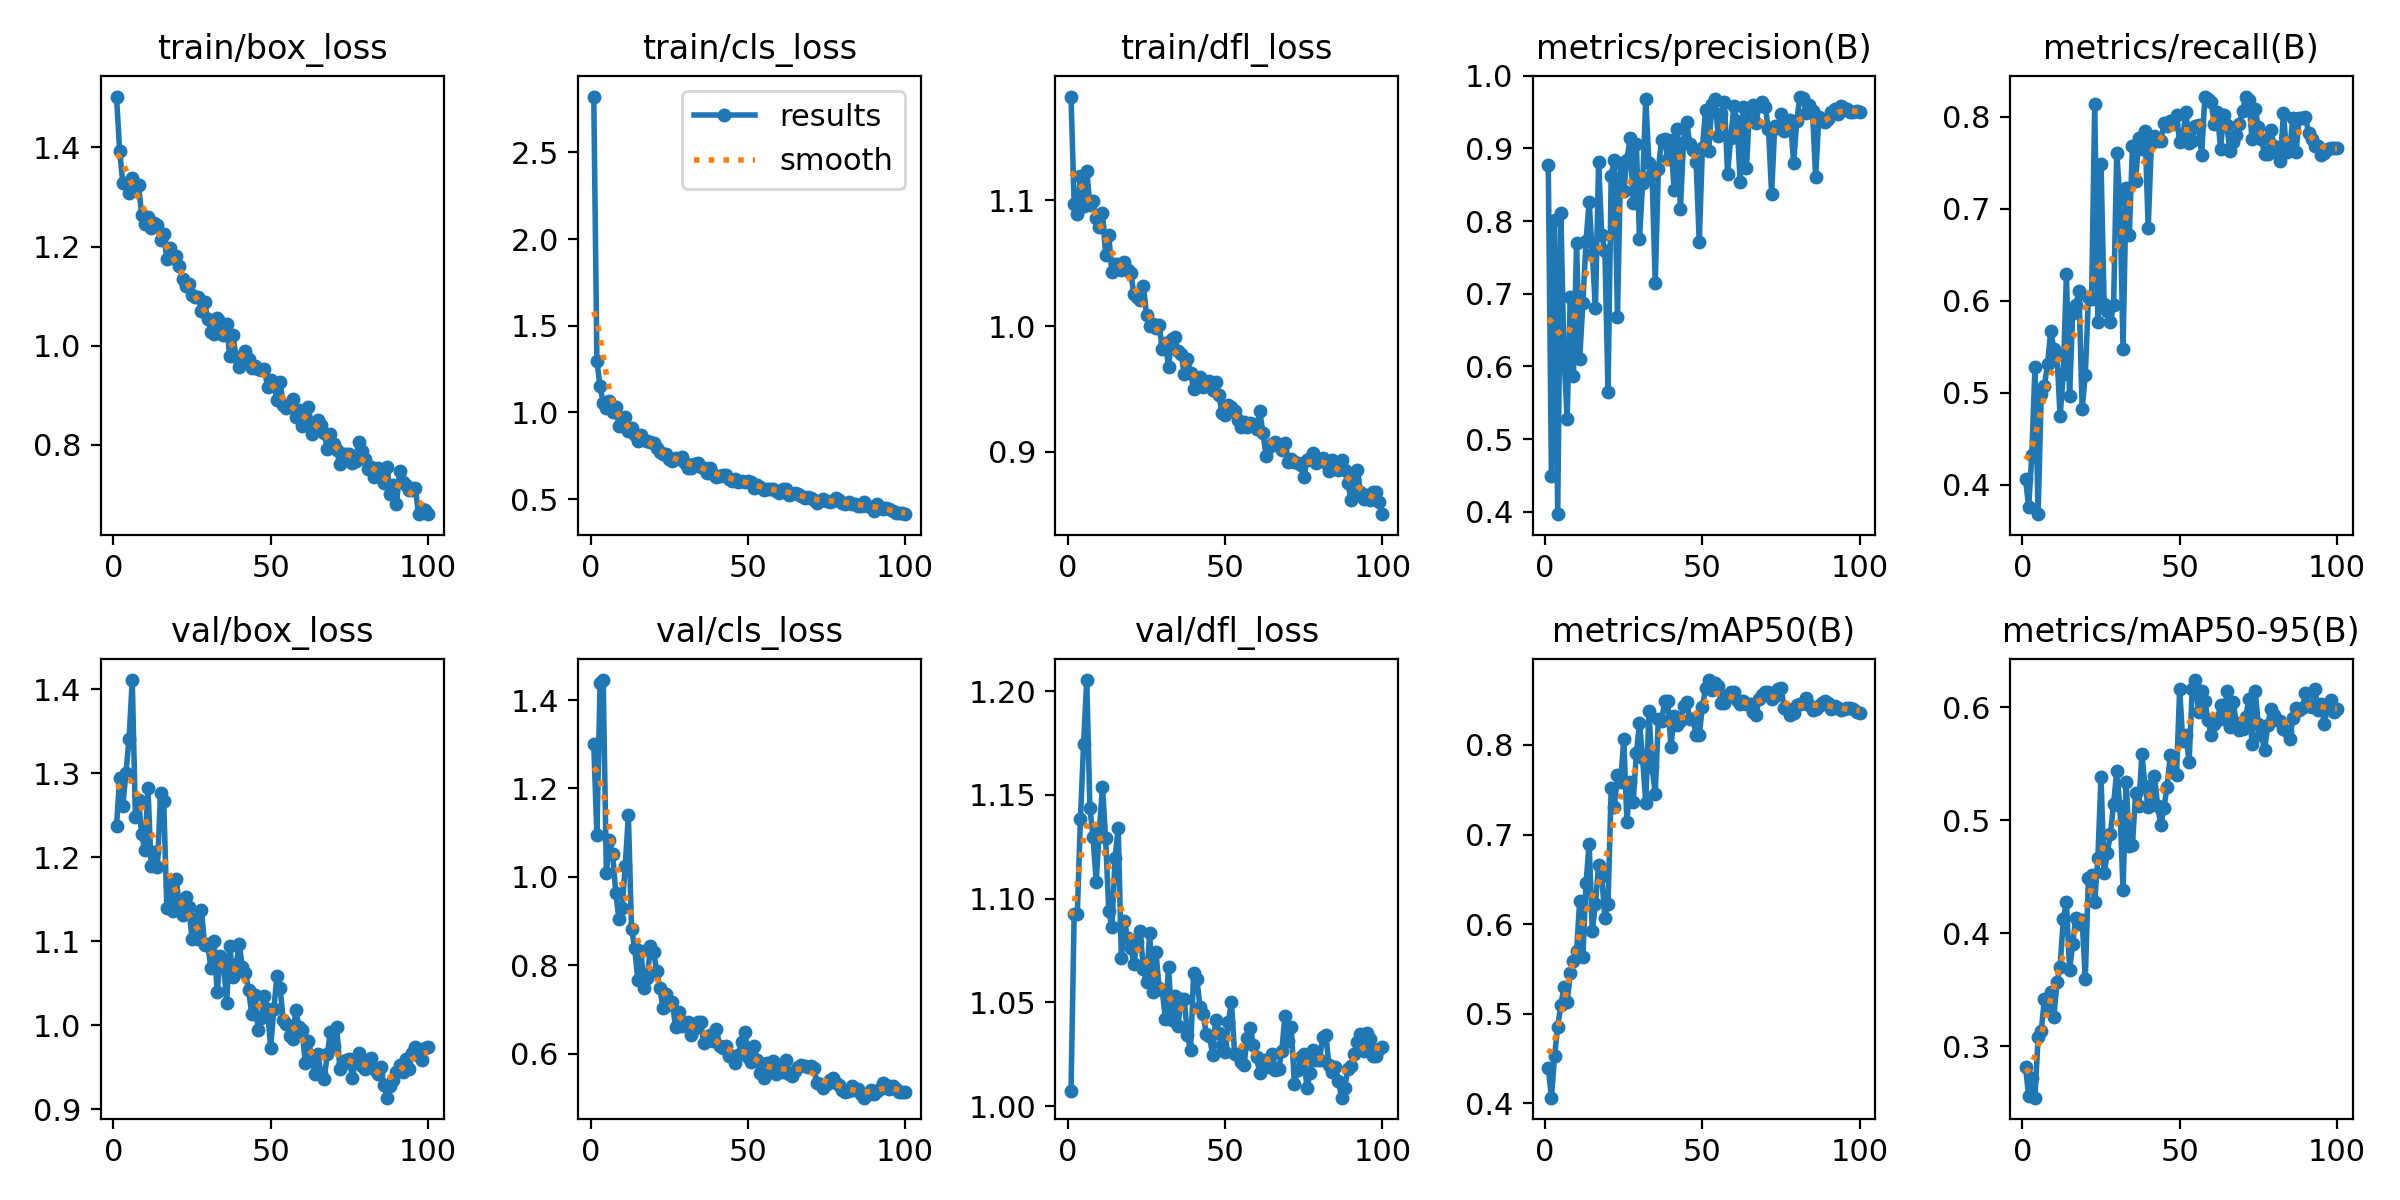

In [9]:
# -------- VISUALIZE TRAINING LOSSES AND METRICS --------
#TO-DO: Add the code to visualize the training losses and metrics
results_path = "/content/runs/detect/train/results.png"
Image(filename=results_path, width=600)


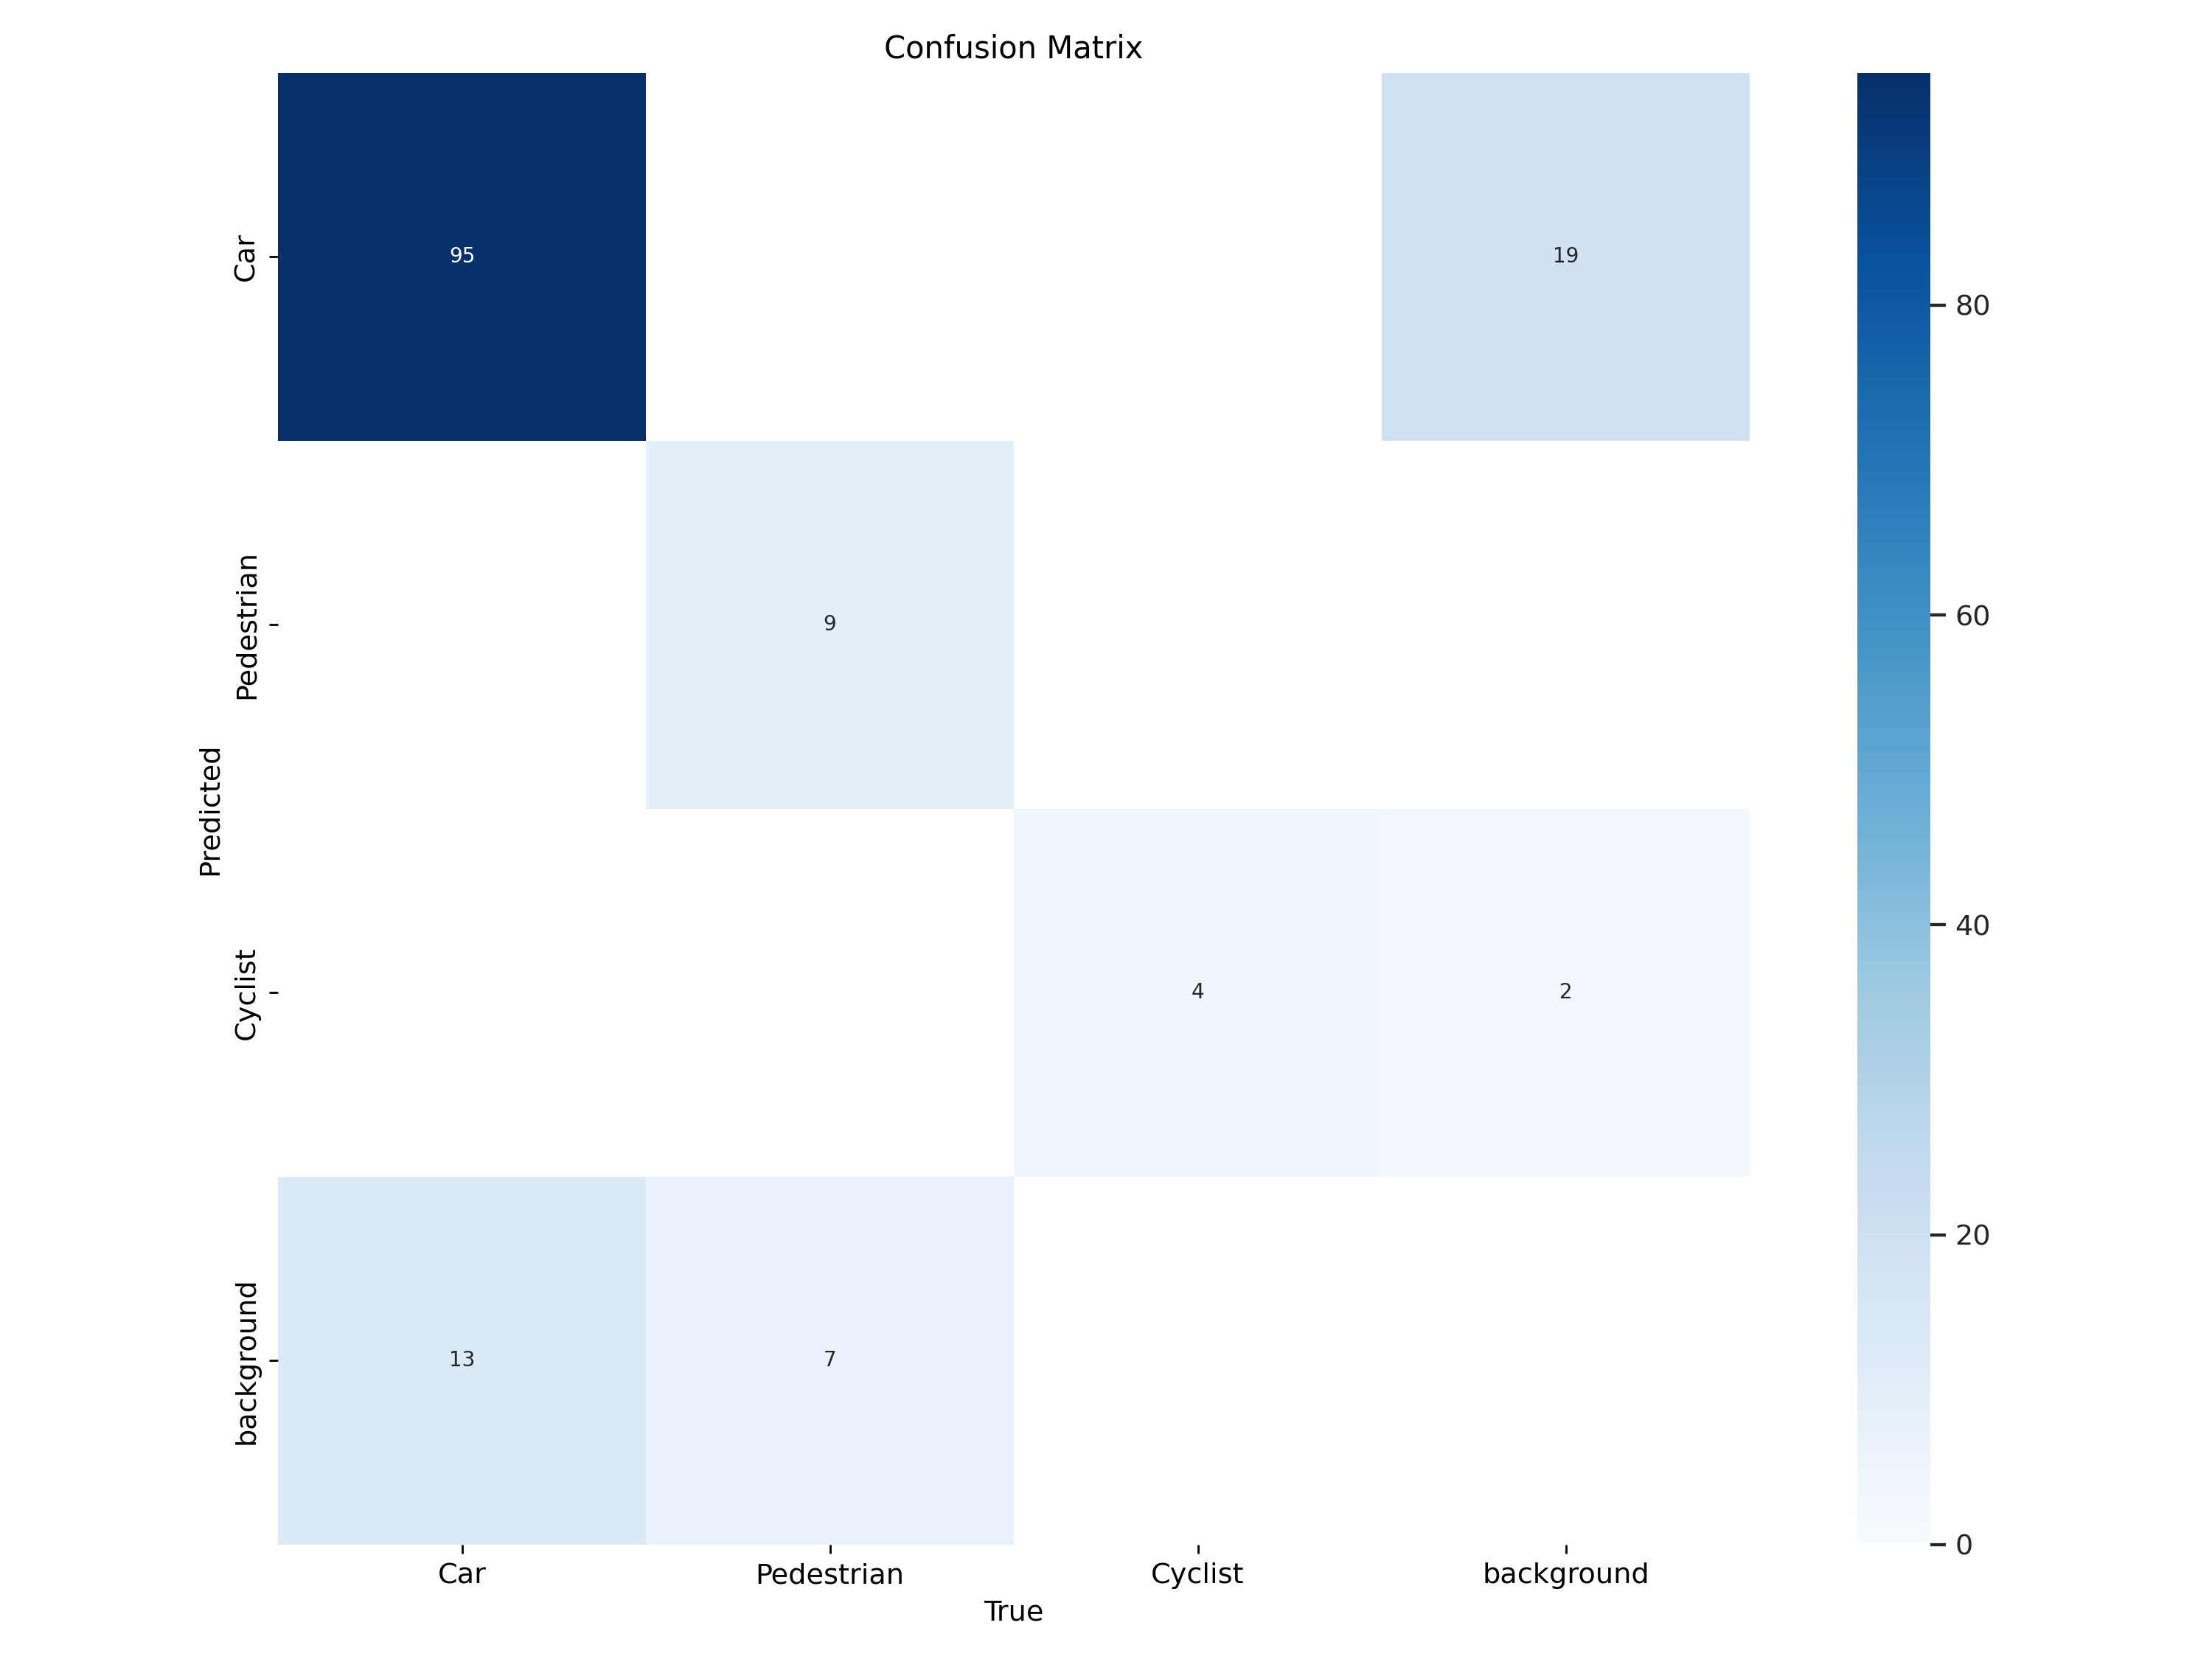

In [10]:
# ------ VISUALIZE CONFUSION MATRIX --------
#TO-DO: Add the code to visualize the confusion matrix
results_path = "/content/runs/detect/train/confusion_matrix.png"
Image(filename=results_path, width=600)


image 1/1 /content/datasets/kitti_subset/images/testing/image_2/000000.png: 224x640 1 Car, 58.0ms
Speed: 2.4ms preprocess, 58.0ms inference, 15.7ms postprocess per image at shape (1, 3, 224, 640)


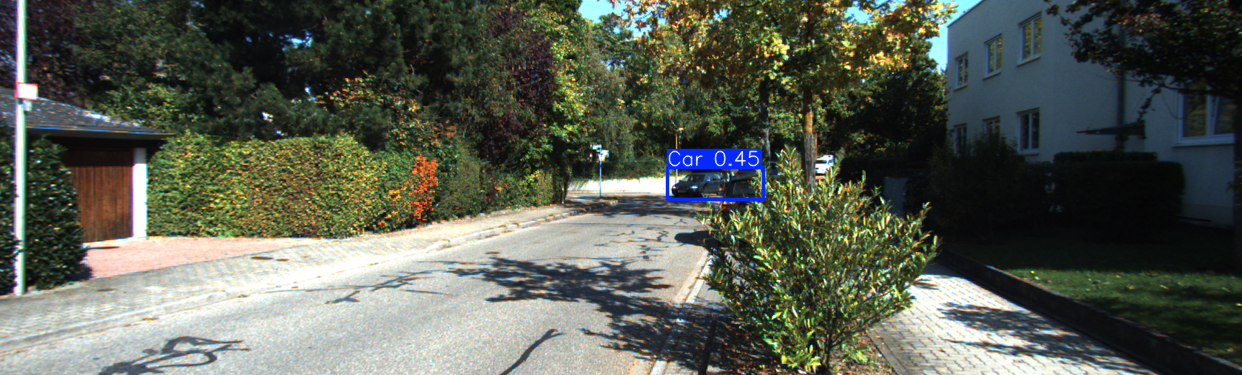

In [14]:
# -------- RUN INFERENCE AND PLOT SAMPLE OUTPUTS --------
#TO-DO: Add the code to run inference and visualize the outputs results
annotated_img = yolo_model("/content/datasets/kitti_subset/images/testing/image_2/000000.png")
annotated_img[0].show()


## Question

Comment on the performance of the model based on the visualizations you made and discuss the inference speed versus performance for YOLO on the driving datasets. Do you think we can use YOLO online on autonomous cars?

## Ans